In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, axis=-1).astype(np.float32) / 255

In [3]:
batch_size = 64
dataset = np.reshape(dataset, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU


noise_dim = 150

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(noise_dim,)),
    layers.Dense(7 * 7 * 256),
    layers.Reshape(target_shape=(7, 7, 256)),
    layers.Conv2DTranspose(256, 3, strides=2, padding="SAME"),
    LeakyReLU(0.1),
    layers.Conv2DTranspose(128, 3, strides=2, padding="SAME"),
    LeakyReLU(0.1),
    layers.Conv2DTranspose(1, 3, padding="SAME", activation="sigmoid")
])
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    layers.Conv2D(256, 3, strides=2, padding="SAME", activation='relu'),
    layers.Conv2D(128, 3, strides=2, padding="SAME", activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
optmG = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
optmD = keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)

lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

gAccMetric = keras.metrics.BinaryAccuracy()
dAccMetric = keras.metrics.BinaryAccuracy()

In [7]:
@tf.function
def trainGstep(data):
  BatchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(BatchSize, noise_dim))
  y_true = tf.ones(BatchSize, 1)
  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generator_loss = lossFn(y_true, y_pred)
  grads = tape.gradient(generator_loss, generator.trainable_weights)
  optmG.apply_gradients(zip(grads, generator.trainable_weights))
  gAccMetric.update_state(y_true, y_pred)
  return{
      "g_loss": generator_loss,
      "g_acc": gAccMetric.result()
  }


In [8]:
@tf.function
def trainDstep(data):
  BatchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(BatchSize, noise_dim))

  y_true = tf.concat([tf.ones(BatchSize, 1), tf.zeros(BatchSize, 1)], axis=0)

  with tf.GradientTape() as tape:
    fake = generator(noise) #cria um vetor de imagens falsas

    print(fake.shape)
    x = tf.concat([data, fake], axis=0) #junta o vetor falso com o vetor de imagens verdadeiras
    y_pred = discriminator(x) #analisa com o descriminador
    discriminator_loss = lossFn(y_true, y_pred)
  grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
  optmD.apply_gradients(zip(grads, discriminator.trainable_weights))
  dAccMetric.update_state(y_true, y_pred)
  return{
      "d_loss": discriminator_loss,
      "d_acc": dAccMetric.result()
  }


In [9]:
import matplotlib.pyplot as plt

def plotImages(model):
  images = model(np.random.normal(size=(81, noise_dim)))
  plt.figure(figsize=(9, 9))

  for i, image in enumerate(images):
    plt.subplot(9, 9, i+1)
    plt.imshow(np.squeeze(image, -1), cmap='Greys_r')
    plt.axis('off')
  plt.show()

(64, 28, 28, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


(64, 28, 28, 1)
(48, 28, 28, 1)
E:0, Loss G:2.3580, Loss D:0.2496, Acc G:%4.76, Acc D:%91.85


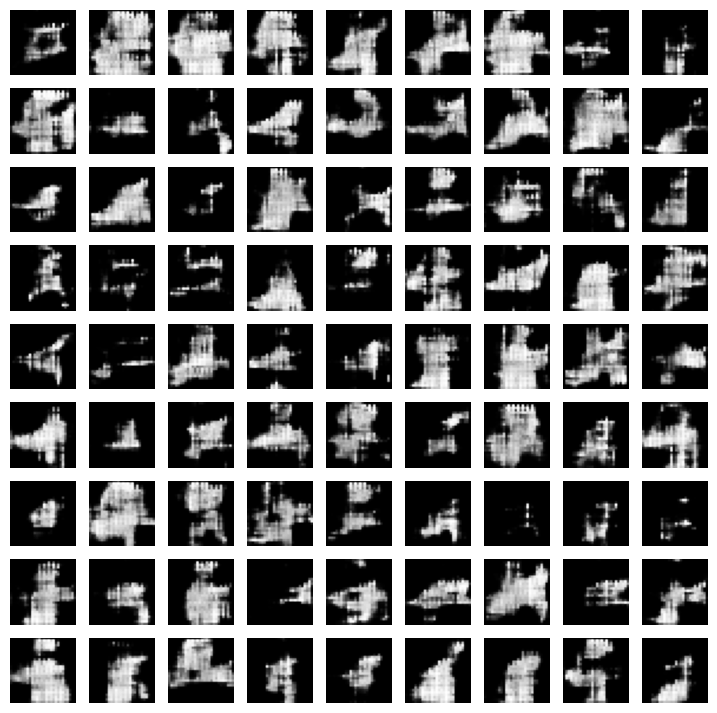

E:1, Loss G:2.2101, Loss D:0.2699, Acc G:%5.81, Acc D:%90.77
E:2, Loss G:1.9755, Loss D:0.2969, Acc G:%6.66, Acc D:%89.93


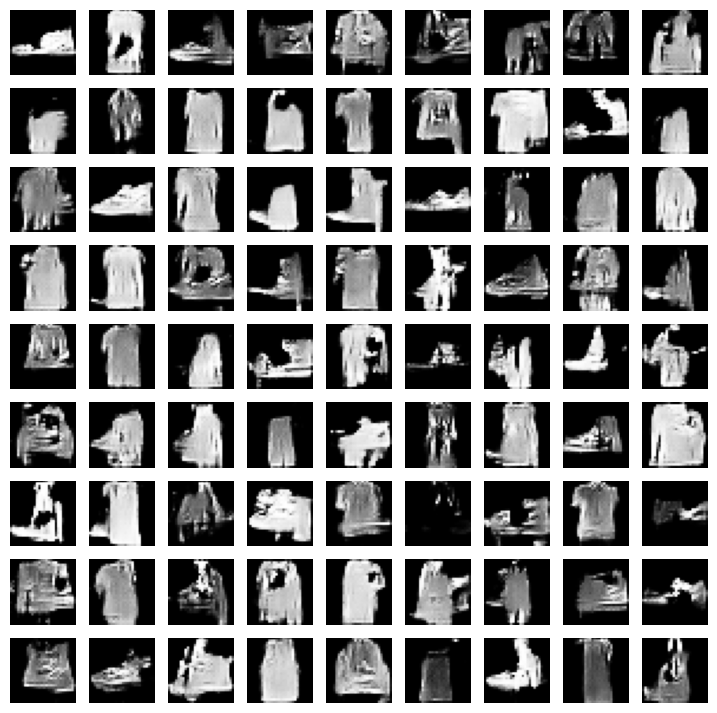

E:3, Loss G:2.2109, Loss D:0.2735, Acc G:%7.12, Acc D:%89.60
E:4, Loss G:2.3974, Loss D:0.2492, Acc G:%7.23, Acc D:%89.60


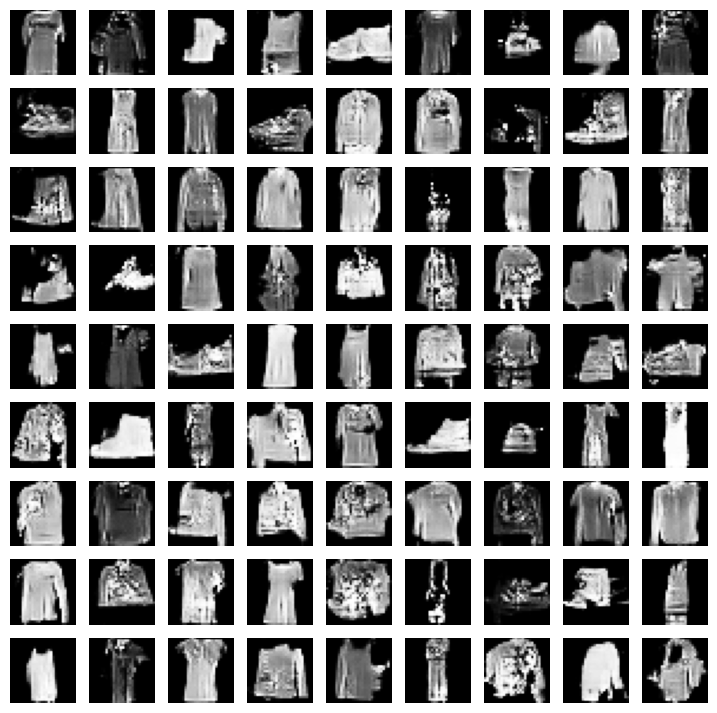

E:5, Loss G:2.5254, Loss D:0.2319, Acc G:%7.09, Acc D:%89.78
E:6, Loss G:2.6018, Loss D:0.2179, Acc G:%6.85, Acc D:%90.02


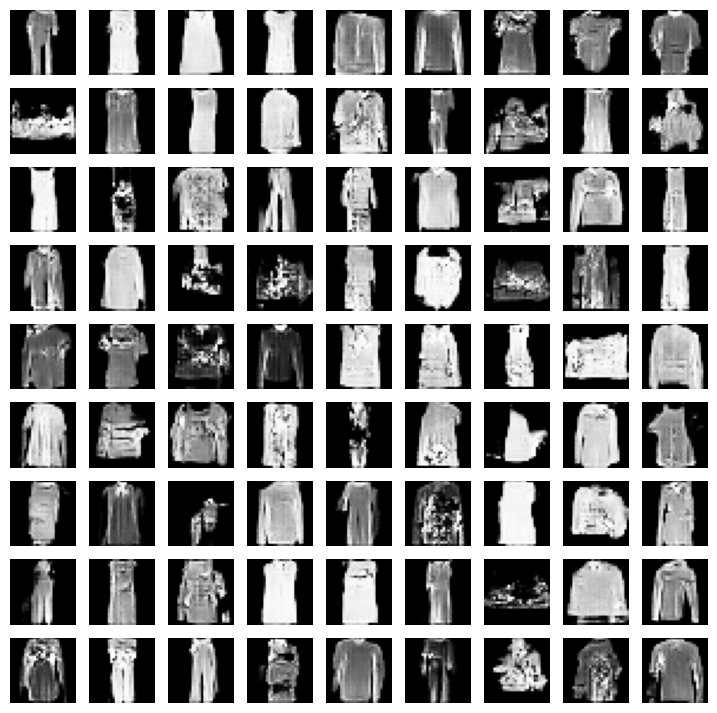

E:7, Loss G:2.5898, Loss D:0.2197, Acc G:%6.63, Acc D:%90.22
E:8, Loss G:2.5783, Loss D:0.2177, Acc G:%6.44, Acc D:%90.35


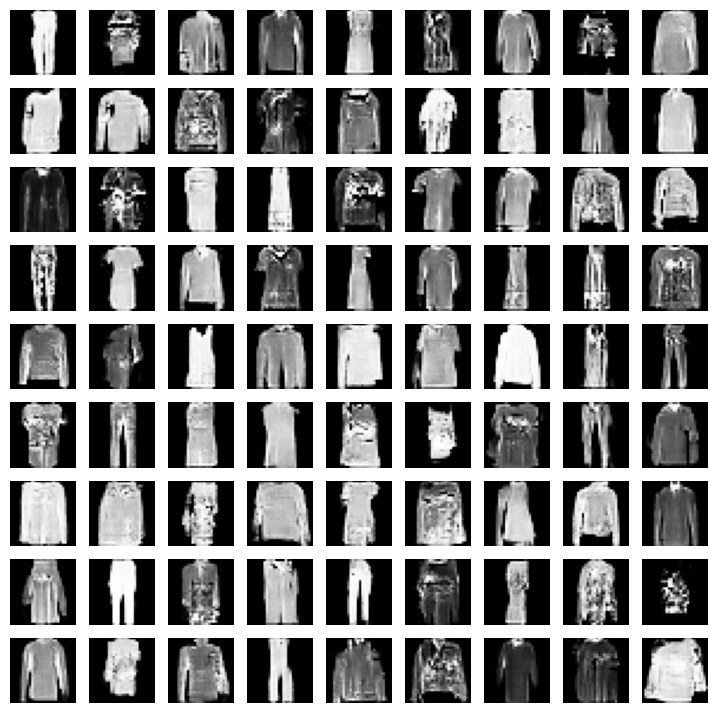

E:9, Loss G:2.6326, Loss D:0.2123, Acc G:%6.29, Acc D:%90.47
E:10, Loss G:2.7000, Loss D:0.2066, Acc G:%6.16, Acc D:%90.59


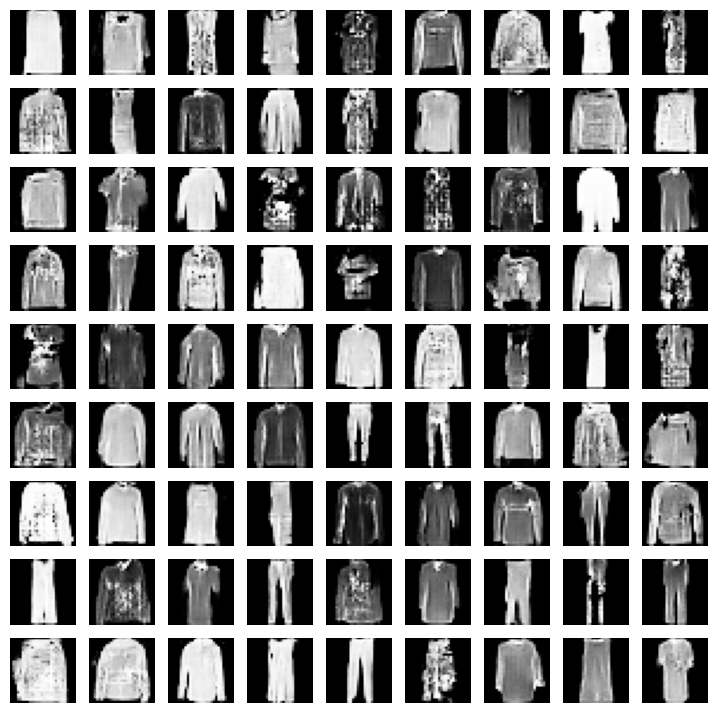

E:11, Loss G:2.7527, Loss D:0.2009, Acc G:%6.03, Acc D:%90.71
E:12, Loss G:2.7945, Loss D:0.1998, Acc G:%5.92, Acc D:%90.81


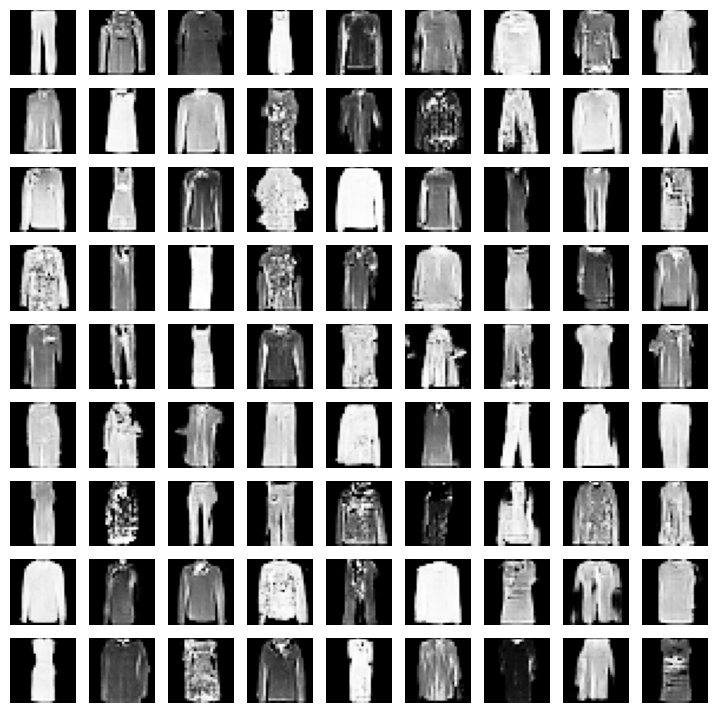

E:13, Loss G:2.8607, Loss D:0.1933, Acc G:%5.82, Acc D:%90.92
E:14, Loss G:2.9388, Loss D:0.1864, Acc G:%5.73, Acc D:%91.03


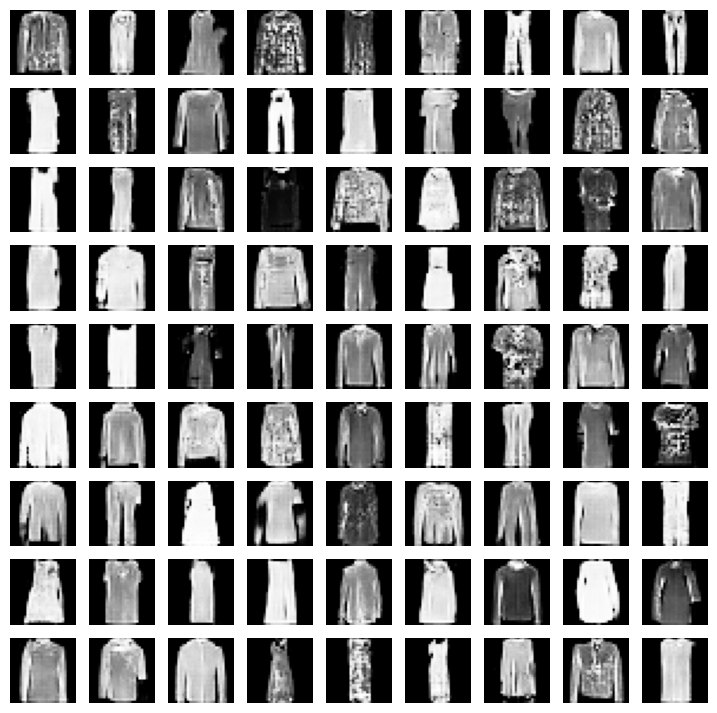

E:15, Loss G:2.9892, Loss D:0.1839, Acc G:%5.63, Acc D:%91.14
E:16, Loss G:3.0614, Loss D:0.1776, Acc G:%5.54, Acc D:%91.24


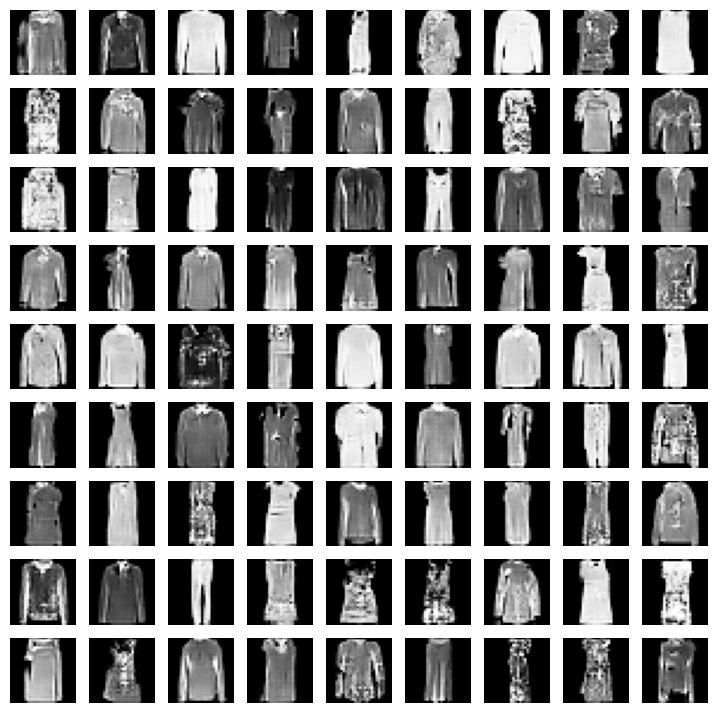

E:17, Loss G:3.0894, Loss D:0.1751, Acc G:%5.47, Acc D:%91.34
E:18, Loss G:3.1528, Loss D:0.1716, Acc G:%5.39, Acc D:%91.44


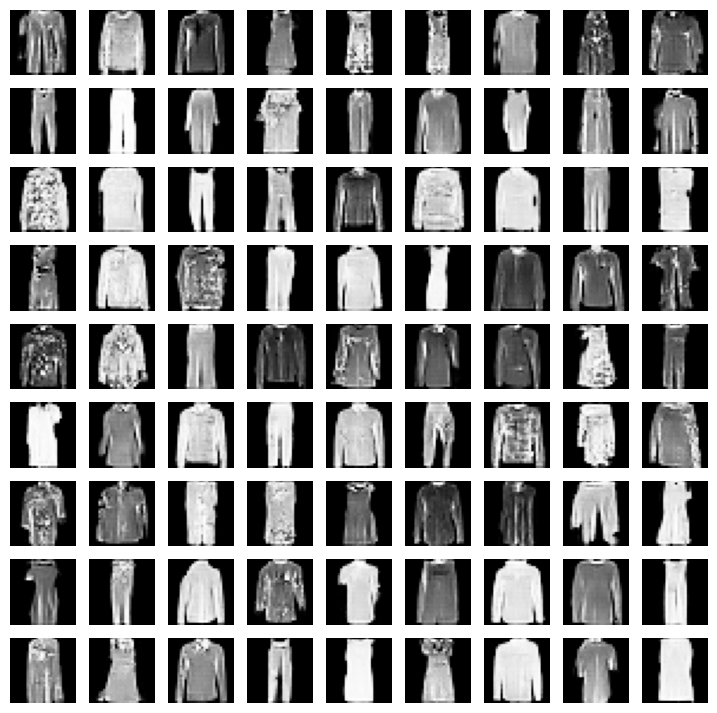

E:19, Loss G:3.2043, Loss D:0.1686, Acc G:%5.32, Acc D:%91.54


In [10]:
for epoch in range(20):
  dlossSum = 0
  daccSum = 0
  glossSum = 0
  gaccSum = 0
  cnt = 0

  for batch in dataset:
   dloss= trainDstep(batch)
   dlossSum += dloss["d_loss"]
   daccSum += dloss["d_acc"]
   gloss = trainGstep(batch)
   glossSum += gloss["g_loss"]
   gaccSum += gloss["g_acc"]
   cnt += 1

  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(epoch, glossSum/cnt, dlossSum/cnt, 100*gaccSum/cnt, 100*daccSum/cnt))

  if epoch % 2 == 0:
    plotImages(generator)

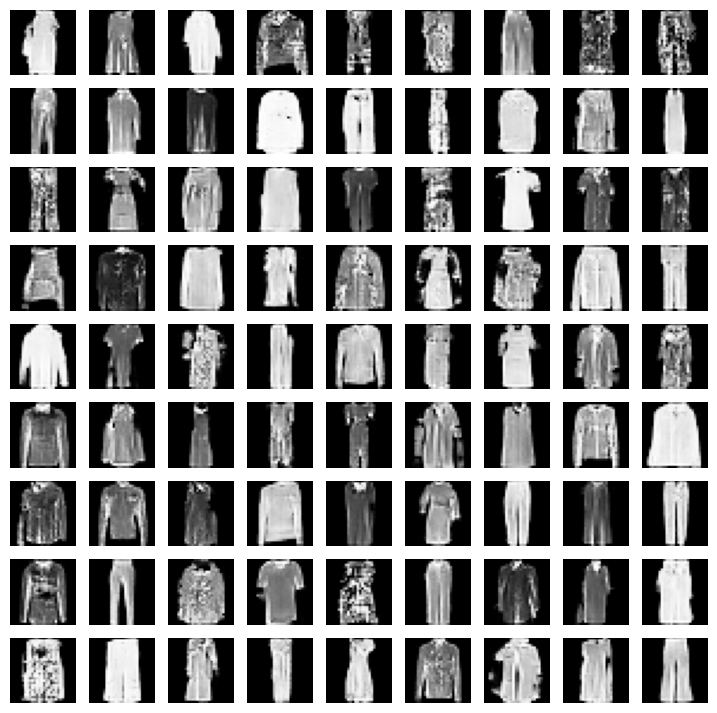

In [11]:
images = generator(np.random.normal(size=(81, noise_dim)))

# plot the generated samples
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

plt.show();

In [12]:
noise = np.random.normal(0, 1, (1, 150))  # Vetor latente aleatório
generated_image = generator.predict(noise)
generated_image = 0.5 * generated_image + 0.5  # Normaliza para [0, 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


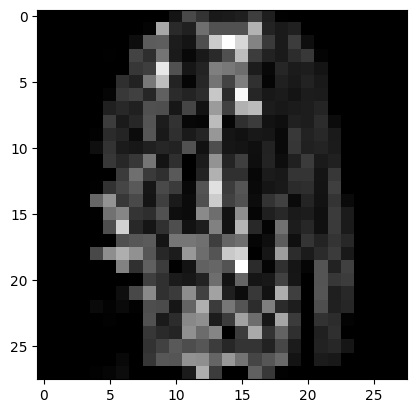

In [13]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
discriminator.predict(generated_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


array([[0.9865073]], dtype=float32)

In [38]:
real=[]
falso=[]
real_conta=0
falso_conta=0
while len(real) < 10 or len(falso) < 10:
  noise = np.random.normal(0, 1, (1, 150))
  generated_image = generator.predict(noise) #gera imagens falsas
  generated_image = 0.5 * generated_image + 0.5
  if discriminator.predict(generated_image) >= 0.70 and len(real)!=10:
    real.append(generated_image)
    real_conta += 1
  elif discriminator.predict(generated_image)<= 0.70 and len(falso)!=10:
    falso.append(generated_image)
    falso_conta +=1
    #preenche dois vetores com 10 imagens cada, um com imagens identificadas como reais e outro com imagens identificadas como falsas


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
falso 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
real 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
real 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
real 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
falso 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
real 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
real 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
real 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
real 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
falso 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


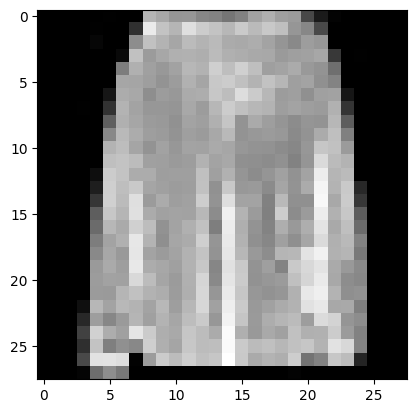

In [43]:
discriminator.predict(falso[0])
imagem = np.squeeze(falso[0])
plt.imshow(imagem, cmap='gray')

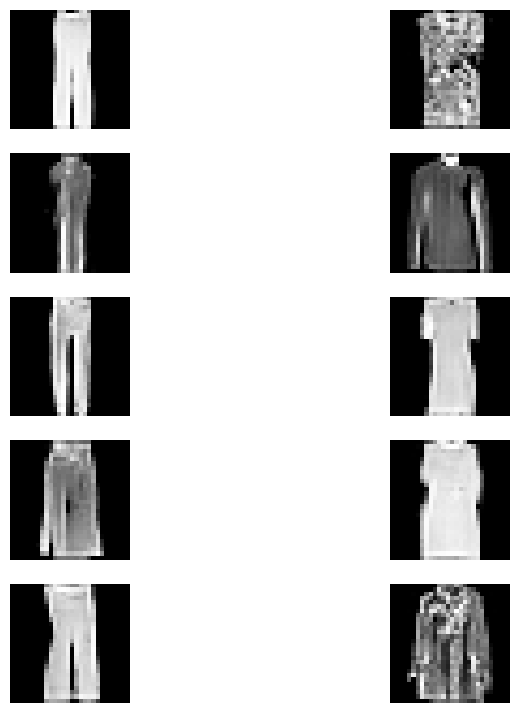

In [46]:
plt.figure(figsize=(9, 9))

for i, image in enumerate(real):
  plt.subplot(5, 2, i+1)
  plt.imshow(np.squeeze(real[i]), cmap="Greys_r")
  plt.axis('off')

plt.show()
#expoe imagens detectadas como verdadeiras

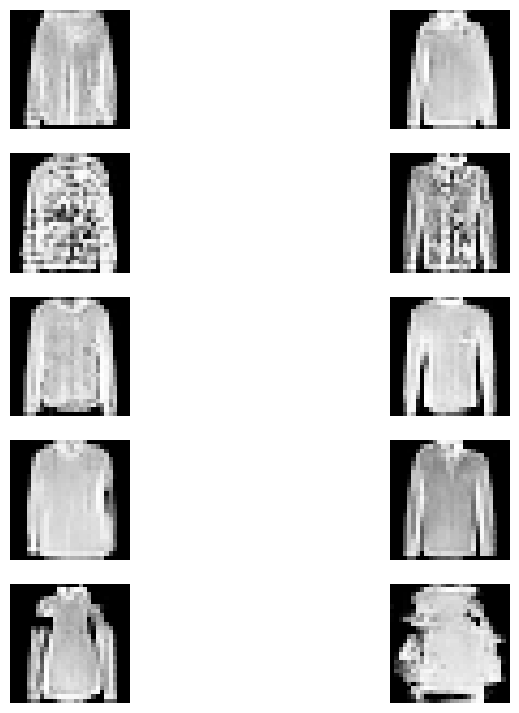

In [52]:
plt.figure(figsize=(9, 9))

for i, image in enumerate(falso):
  plt.subplot(5, 2, i+1)
  plt.imshow(np.squeeze(falso[i]), cmap="Greys_r")
  plt.axis('off')

plt.show()
#Expõe imagens detectadas como falsas